In [ ]:
%%capture
!pip install cohere datasets

In [ ]:
import cohere
from datasets import load_dataset
import os
import numpy as np
from collections import Counter
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
dataset = load_dataset("rjac/all-the-news-2-1-Component-one-embedding")

Using custom data configuration rjac--all-the-news-2-1-Component-one-embedding-f2c65fc4e73cbdb8
Reusing dataset parquet (/root/.cache/huggingface/datasets/rjac___parquet/rjac--all-the-news-2-1-Component-one-embedding-f2c65fc4e73cbdb8/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset = dataset.shuffle(8564)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rjac___parquet/rjac--all-the-news-2-1-Component-one-embedding-f2c65fc4e73cbdb8/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8/cache-308dfeba6153ad99.arrow


Number of cluster with a Small Sample

In [ ]:
subset = dataset.shuffle(74)["train"].select(range(50_000))
#subset = dataset["train"]

In [ ]:
subset 

Dataset({
    features: ['article_idx', 'year', 'month', 'paragraph_position', 'paragraph', 'embedding'],
    num_rows: 50000
})

In [ ]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    silhouette = []
    for k in ks:
        kmeans = MiniBatchKMeans(n_clusters = k, max_iter = 10_000,n_init=20, batch_size= 256 * os.cpu_count() - 5 ,random_state = 654).fit(X)
        inertias.append(kmeans.inertia_)
        cluster_labels = kmeans.predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette.append(silhouette_avg)

    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')
    plt.show()

    plt.plot(ks, silhouette)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('silhouette')
    plt.title('silhouette Score')

In [ ]:
#cluster_model = MiniBatchKMeans(n_clusters = 100, max_iter = 10_000,n_init=20, batch_size=batch_size ,random_state = 654)

In [ ]:
subset.set_format(type='numpy', columns=['embedding'],output_all_columns=True)

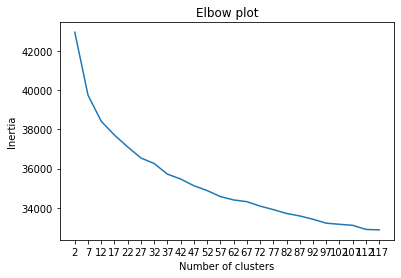

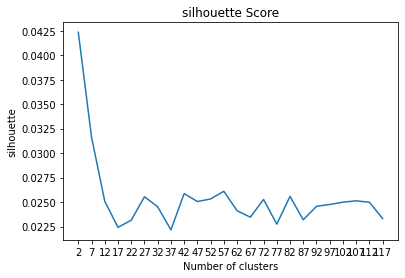

In [ ]:
visualize_elbow(subset["embedding"],range(2,120, 5))

In [ ]:
subset = dataset["train"]

In [ ]:
cluster_model = MiniBatchKMeans(n_clusters = 82, max_iter = 10_000,n_init=20, batch_size= 256 * os.cpu_count() - 5 ,random_state = 654)

In [ ]:
subset

Dataset({
    features: ['article_idx', 'year', 'month', 'paragraph_position', 'paragraph', 'embedding'],
    num_rows: 2475520
})

In [ ]:
subset.set_format(type='numpy', columns=['embedding'],output_all_columns=True)

In [ ]:
%%time
cluster_model.fit(subset["embedding"])

CPU times: user 18min 20s, sys: 1h 2min 16s, total: 1h 20min 36s
Wall time: 3min 23s


MiniBatchKMeans(batch_size=10235, max_iter=10000, n_clusters=82, n_init=20,
                random_state=654)

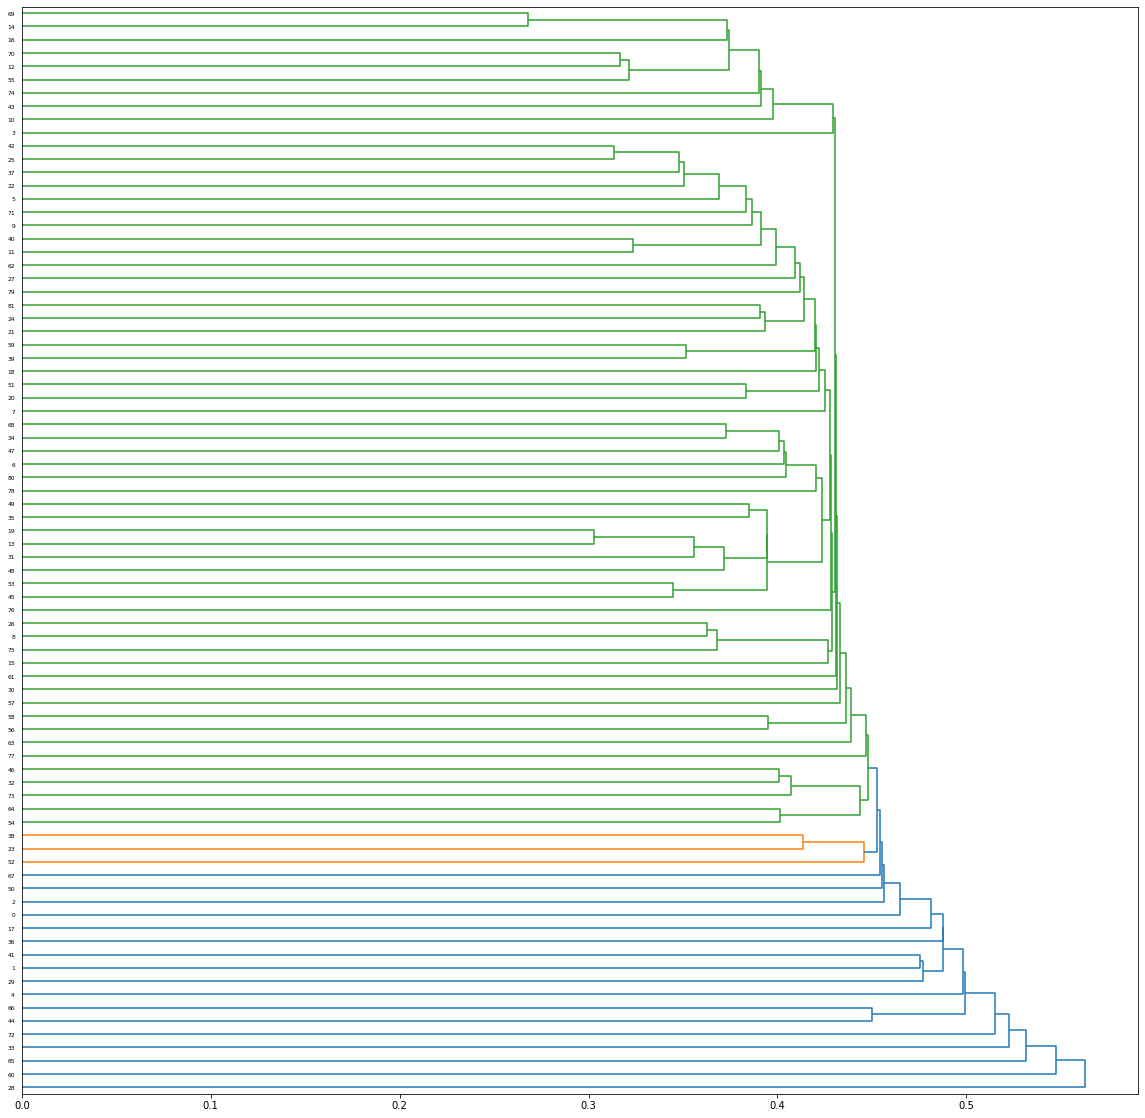

In [ ]:
plt.figure(figsize=(20, 20))
plt.rcParams['font.size'] = 10
hierarchy_cluster = hierarchy.linkage(cluster_model.cluster_centers_, 'single')
dn = hierarchy.dendrogram(hierarchy_cluster, orientation='right',color_threshold=0.45)

In [ ]:
label_ = hierarchy.fcluster(hierarchy_cluster, 0.4225,criterion='distance')
middle_cutpoint_cluster = {c:i for c,i in zip(np.unique(cluster_model.labels_),label_)}

In [ ]:
label_ = hierarchy.fcluster(hierarchy_cluster, 0.45,criterion='distance')
high_cutpoint_cluster = {c:i for c,i in zip(np.unique(cluster_model.labels_),label_)}

In [ ]:
pd.DataFrame({"cluster":cluster_model.labels_}).value_counts()

cluster
25         71628
42         55964
49         53487
16         53404
14         47038
           ...  
64         17780
44         17738
58         15767
35         15467
61         13314
Length: 82, dtype: int64

In [ ]:
cluster_num = cluster_model.labels_
#def pro(batch,i):
#    cluster = [cluster_num[idx] for idx in i]
#    return {"cluster":cluster}

In [ ]:
#subset = subset.map(pro,batched=True,num_proc=os.cpu_count(),with_indices=True)

In [ ]:
subset

Dataset({
    features: ['article_idx', 'year', 'month', 'paragraph_position', 'paragraph', 'embedding'],
    num_rows: 2475520
})

In [ ]:
all_df = pd.DataFrame({"paragraph":subset["paragraph"]})

In [ ]:
all_df["cluster_lvl3"] = cluster_num

In [ ]:
all_df["cluster_lvl2"] = all_df.cluster.map(middle_cutpoint_cluster)

In [ ]:
all_df["cluster_lvl1"] = all_df.cluster.map(high_cutpoint_cluster)

In [ ]:
# iterate a list in batches of 50
import itertools
def batch_iter(iterable, batch_size):
    iterator = iter(iterable)
    for first in iterator:
        yield itertools.chain([first], itertools.islice(iterator, batch_size - 1))

In [ ]:
word_frequency = Counter()
for batch in batch_iter(all_df["paragraph"],10_000):
    word_frequency.update([w.lower() for p in list(batch) for w in p.split(" ")])

In [ ]:
print("-------------------------------------------------------------------")
cluster_labels = {}
for c, df in all_df.groupby("cluster_lvl3"):
    
    term_frequency = Counter()
    for batch in batch_iter(df["paragraph"],10_000):
        term_frequency.update([w.lower() for p in list(batch) for w in p.split(" ")])

    average_word_per_cluster = sum(term_frequency.values())/len(term_frequency.values())
    c_idf = {w: np.log(1+(average_word_per_cluster/f)) for w,f in word_frequency.items()}
    cTF_IDF = pd.DataFrame.from_dict({w:tf*c_idf.get(w,0) for w,tf in term_frequency.items()},orient="index")
    top20 = cTF_IDF.sort_values(by=0,ascending=False).head(20).reset_index()["index"].values
    labels = ' , '.join(top20)
    print(labels)
    cluster_labels[c] = labels
    print("------------------------------------------------------------------- {}".format(c))

-------------------------------------------------------------------
bown, , seade , lighthizer’s , ustr , guajardo , nafta’s , cptpp , lighthizer, , tpp-11 , 232” , lighthizer , wto’s , w.t.o. , seade, , ildefonso , rcep , malmstrom , (ustr) , bown , 301”
------------------------------------------------------------------- 0
wr, , rb, , pointsone , gase , maccagnan , nflpa , gruden , owned). , tunsil , foles , burfict , quarterbacks , garoppolo , all-pro , roethlisberger , hayden: , 



start: , mcadoo , clowney , belichick
------------------------------------------------------------------- 1
rajoy’s , puigdemont’s , junqueras , fayulu , bouteflika’s , puigdemont , bouteflika , karoui , torra , chamisa , podemos, , rajoy , dlamini-zuma , ciudadanos, , esquerra , fayulu, , catalans , fpo , fillon’s , ramazani
------------------------------------------------------------------- 2
gardendale , lockport , beutner , #nationalwalkoutday , no-excuses , here »

 , bump-fire , erpo , caputo-pearl

In [ ]:
promt_template = 'Given some keywords of a cluster of documents, this program will generate the Category, Sub Category, and Topic description. Here are some examples:\n\nKeywords: tweets , twitter , twitters , timeline , users , feature , twttr , tweet , replies , algorithmic .\nGeneration: the category is \"Technology\" , the Sub Category is \"Social Media\" and the topic should be \"twitter\".\n--\nKeywords: art , museum , artists , exhibition , paintings , artist , painting , gallery , museums , works .\nGeneration: the category is \"Cultural\" , the Sub Category is \"Art\" and the topic should be \"museum\" .\n--\nKeywords: eur , million euros , euros , euros year , gdynia newsroom , gdynia , fy , year ago , h1 , euros versus dollars , gdynia .\nGeneration: the category is \"Finance\" , the Sub Category is \"Economics\" and the topic should be \"EUR\" .\n--\nKeywords: hiv , aids , prep , living hiv , hivaids , antiretroviral , truvada , virus , infections , treatment .\nGeneration: the category is \"Medicine\" , the Sub Category is \"Healthcare\" and the topic should be \"Hiv/Aids\" .\n--\nKeywords: {} .\nGeneration:'

In [ ]:
string = "ellaria , gendry , varys , olenna , melisandre , arya's , littlefinger , lyanna , theon , cersei. , cersei , arya’s , rhaegar , missandei , cersei’s"

In [ ]:
import re
def remove_non_alphanumeric(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\'s', '', text)
    text = re.sub(r'[^\w-]', '', text)
    return text

In [ ]:
import cohere
co = cohere.Client('COHERE_API_KEY')
cluster_description = {}
for k in cluster_labels:
    words = np.unique([remove_non_alphanumeric(w) for w in cluster_labels.get(k).split(" , ")])
    response = co.generate(
        model='xlarge',
        prompt=promt_template.format(' , '.join(words)),
        max_tokens=30,
        temperature=0.4,
        k=0,
        p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop_sequences=["--"],
        return_likelihoods='NONE'
    )
    
    cluster_description[k] = response.generations[0].text

In [ ]:
cluster_description

{0: ' the category is "Economy" , the Sub Category is "Trade" and the topic should be "TPP" .\n--',
 1: ' the category is "Sports" , the Sub Category is "Football" and the topic should be "NFL" .\n--',
 2: ' the category is "Politics" , the Sub Category is "Government" and the topic should be "Algeria" .\n--',
 3: ' the category is "Politics" , the Sub Category is "Law" and the topic should be "guns" .\n--',
 4: ' the category is "Environment" , the Sub Category is "Climate" and the topic should be "Carbon" .\n--',
 5: ' the category is "Finance" , the Sub Category is "Economics" and the topic should be "Non-performance" .\n--',
 6: ' the category is "Literature" , the Sub Category is "Fiction" and the topic should be "Fiction" .\n--',
 7: ' the category is "Entertainment" , the Sub Category is "Media" and the topic should be "streaming" .\n--',
 8: ' the category is "Crime" , the Sub Category is "Murder" and the topic should be "murder" .\n--',
 9: ' the category is "Technology" , the

In [ ]:
import cohere
co = cohere.Client('APIKEY')
response = co.generate(
  model='xlarge',
  prompt=promt_template.format(string),
  max_tokens=30,
  temperature=0.4,
  k=0,
  p=1,
  frequency_penalty=0,
  presence_penalty=0,
  stop_sequences=["--"],
  return_likelihoods='NONE')
print('Prediction: {}'.format(response.generations[0].text))

Prediction:  the category is "Entertainment" , the Sub Category is "TV Series" and the topic should be "Game of Thrones" .
--


In [ ]:
all_df = all_df.drop(["cluster","sub_cluster"],axis=1)

In [ ]:
cluster_description

{0: ' the category is "Economy" , the Sub Category is "Trade" and the topic should be "TPP" .\n--',
 1: ' the category is "Sports" , the Sub Category is "Football" and the topic should be "NFL" .\n--',
 2: ' the category is "Politics" , the Sub Category is "Government" and the topic should be "Algeria" .\n--',
 3: ' the category is "Politics" , the Sub Category is "Law" and the topic should be "guns" .\n--',
 4: ' the category is "Environment" , the Sub Category is "Climate" and the topic should be "Carbon" .\n--',
 5: ' the category is "Finance" , the Sub Category is "Economics" and the topic should be "Non-performance" .\n--',
 6: ' the category is "Literature" , the Sub Category is "Fiction" and the topic should be "Fiction" .\n--',
 7: ' the category is "Entertainment" , the Sub Category is "Media" and the topic should be "streaming" .\n--',
 8: ' the category is "Crime" , the Sub Category is "Murder" and the topic should be "murder" .\n--',
 9: ' the category is "Technology" , the

In [ ]:
import re
def extract_text(text):
    # Extract the text between ""
    text = re.findall(r'"([^"]*)"',text)
    # If there is no text, return an empty string
    if len(text) == 0:
        return ["None","None","None"]
    # If there is text, return the text
    else:
        return text

In [ ]:
vector_description = {k:extract_text(i) for k, i in cluster_description.items()}

In [ ]:
all_df["category_subCategory_topic"] = all_df.cluster_lvl3.map(vector_description)

In [ ]:
all_df.to_pickle("all_df.pickle")

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
np.array_split

In [ ]:
all_df = pd.read_pickle("/content/all_df.pickle")

In [ ]:
all_df = None

In [ ]:
for i,sdf in enumerate(np.array_split(all_df,20)):
    sdf.to_json("data/all_df{}.json".format(i),orient="records",lines=True)

In [ ]:
from datasets import Dataset,load_dataset
batch_df = load_dataset("json",data_dir="/content/data/")

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Using custom data configuration default-bb1c632c967683cb


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-bb1c632c967683cb/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
batch_df["train"][1040235]

{'category_subCategory_topic': ['Politics', 'Government', 'Algeria'],
 'cluster_lvl1': 10,
 'cluster_lvl2': 27,
 'cluster_lvl3': 2,
 'paragraph': 'BRUSSELS — Belgian voters elected the first black mayor in their nation’s history on Sunday — a man originally from the huge swath of central Africa that Belgium brutalized for generations, in one of the harshest of the European colonial regimes. Pierre Kompany, 71, who fled the Democratic Republic of Congo as a refugee in 1975, will be sworn in before the end of the year as the mayor of one of Brussels’s 19 boroughs, Ganshoren, where he was elected by an overwhelmingly white community. “My success, my election, shows the direction of the march of history, which is towards a more peaceful history,” Mr. Kompany said on Monday. “I think one has to regard this as a victory for humanity as a whole.” His election, he said, shows that Belgium has made significant progress in integrating a people whom, not so long ago, it systematically suppressed,

In [ ]:
batch_df.push_to_hub("rjac/all-the-news-2-1-Component-ones-cluster-labels",max_shard_size="2GB",private=False,token="HF_API_KEY")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1951: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  FutureWarning,


In [ ]:
batch_df

DatasetDict({
    train: Dataset({
        features: ['paragraph', 'cluster_lvl1', 'cluster_lvl3', 'cluster_lvl2', 'category_subCategory_topic'],
        num_rows: 2475520
    })
})

In [ ]:

labels_df = pd.DataFrame(all_df.category_subCategory_topic.to_list(), columns = ['category', 'sub_category', 'cluster'])

In [ ]:
labeled_df = pd.concat([all_df,labels_df],axis=1)

In [ ]:
labeled_df.groupby(["category"]).apply(lambda x: np.unique(x["sub_category"].values) )

category
Aircraft                                             [Aircraft Design]
Animals                                                         [Pets]
Art                                                         [Painting]
Astrology                                                  [Horoscope]
Automotive                                                      [Cars]
Cosmetics                                                   [Skincare]
Crime                                                         [Murder]
Economy                                                        [Trade]
Education                                                   [Language]
Electronics                                                [Computers]
Employment                                                      [Work]
Energy                                                           [Oil]
Entertainment                    [Celebrity, Media, Movies, TV Series]
Environment                                                  [Climat

In [ ]:
labeled_df.query("category == 'Environment'").sample()["paragraph"].values

array(['TORONTO, Dec 2 (Reuters) - The premiers of Canada\'s provincial and territorial governments began meeting on Monday to discuss their demands to Prime Minister Justin Trudeau\'s new government as frustration simmers in the Western oil patch. The group, known as the Council of the Federation, is gathering for the first time since Trudeau\'s Liberals failed to win a seat in either Alberta or Saskatchewan, the heart of the country\'s struggling oil industry, in the October national election. The sense of western alienation stems from the economic difficulties these provinces have faced since the 2014/15 global oil price crash, which has driven unemployment up higher than the national average. Alberta Premier Jason Kenney is pushing for changes to a federal program that funnels economic aid to the provinces, to allow higher transfers into his province. But he is not likely to find support in the council for this move, because it would likely mean cuts for other provinces. The premie